In [102]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor


In [103]:
# Load datasets
train_df = pd.read_csv('train.csv', parse_dates=['Date'])
features_df = pd.read_csv('features.csv', parse_dates=['Date'])
stores_df = pd.read_csv('stores.csv')
print('Train shape:', train_df.shape)
print('Features shape:', features_df.shape)
print('Stores shape:', stores_df.shape)
print(train_df.head())


Train shape: (421570, 5)
Features shape: (8190, 12)
Stores shape: (45, 3)
   Store  Dept       Date  Weekly_Sales  IsHoliday
0      1     1 2010-02-05      24924.50      False
1      1     1 2010-02-12      46039.49       True
2      1     1 2010-02-19      41595.55      False
3      1     1 2010-02-26      19403.54      False
4      1     1 2010-03-05      21827.90      False


In [104]:
# Aggregate weekly sales by date
weekly_sales = train_df.groupby('Date', as_index=False)['Weekly_Sales'].sum().sort_values('Date')
print('Aggregated weekly sales rows:', weekly_sales.shape[0])
print(weekly_sales.head())


Aggregated weekly sales rows: 143
        Date  Weekly_Sales
0 2010-02-05   49750740.50
1 2010-02-12   48336677.63
2 2010-02-19   48276993.78
3 2010-02-26   43968571.13
4 2010-03-05   46871470.30


In [105]:
# Aggregate feature data by date
agg_dict = {}
num_cols = features_df.select_dtypes(include=[np.number]).columns.tolist()
if 'IsHoliday' in features_df.columns:
    if 'IsHoliday' in num_cols:
        num_cols.remove('IsHoliday')
    agg_dict['IsHoliday'] = 'max'
for c in num_cols:
    agg_dict[c] = 'mean'
features_agg = features_df.groupby('Date').agg(agg_dict).reset_index().sort_values('Date')
print('Aggregated features rows:', features_agg.shape[0])
print(features_agg.head())


Aggregated features rows: 182
        Date  IsHoliday  Store  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0 2010-02-05      False   23.0    34.037333    2.717844        NaN        NaN   
1 2010-02-12       True   23.0    34.151333    2.694022        NaN        NaN   
2 2010-02-19      False   23.0    37.719778    2.672067        NaN        NaN   
3 2010-02-26      False   23.0    39.243556    2.683933        NaN        NaN   
4 2010-03-05      False   23.0    42.917333    2.731200        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  
0        NaN        NaN        NaN  167.730885      8.619311  
1        NaN        NaN        NaN  167.825608      8.619311  
2        NaN        NaN        NaN  167.871686      8.619311  
3        NaN        NaN        NaN  167.909657      8.619311  
4        NaN        NaN        NaN  167.947628      8.619311  


In [106]:
# Merge sales and features
data = pd.merge(weekly_sales, features_agg, on='Date', how='left')
print('Merged data shape:', data.shape)
print(data.head())


Merged data shape: (143, 13)
        Date  Weekly_Sales  IsHoliday  Store  Temperature  Fuel_Price  \
0 2010-02-05   49750740.50      False   23.0    34.037333    2.717844   
1 2010-02-12   48336677.63       True   23.0    34.151333    2.694022   
2 2010-02-19   48276993.78      False   23.0    37.719778    2.672067   
3 2010-02-26   43968571.13      False   23.0    39.243556    2.683933   
4 2010-03-05   46871470.30      False   23.0    42.917333    2.731200   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  167.730885   
1        NaN        NaN        NaN        NaN        NaN  167.825608   
2        NaN        NaN        NaN        NaN        NaN  167.871686   
3        NaN        NaN        NaN        NaN        NaN  167.909657   
4        NaN        NaN        NaN        NaN        NaN  167.947628   

   Unemployment  
0      8.619311  
1      8.619311  
2      8.619311  
3      8.619311  
4      8.

In [107]:
# Create time based features
data = data.sort_values('Date')
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['week'] = data['Date'].dt.isocalendar().week.astype(int)
data['dayofweek'] = data['Date'].dt.dayofweek
print(data[['Date','year','month','week','dayofweek']].head())


        Date  year  month  week  dayofweek
0 2010-02-05  2010      2     5          4
1 2010-02-12  2010      2     6          4
2 2010-02-19  2010      2     7          4
3 2010-02-26  2010      2     8          4
4 2010-03-05  2010      3     9          4


In [108]:
# Create lag features
for l in [1,2,4]:
    data[f'lag_{l}'] = data['Weekly_Sales'].shift(l)
print(data[[c for c in data.columns if 'lag_' in c]].head(8))


         lag_1        lag_2        lag_4
0          NaN          NaN          NaN
1  49750740.50          NaN          NaN
2  48336677.63  49750740.50          NaN
3  48276993.78  48336677.63          NaN
4  43968571.13  48276993.78  49750740.50
5  46871470.30  43968571.13  48336677.63
6  45925396.51  46871470.30  48276993.78
7  44988974.64  45925396.51  43968571.13


In [109]:
# Clean and prepare final dataset
exog_cols = [c for c in ['Temperature','Fuel_Price','CPI','Unemployment'] if c in data.columns]
cols_for_model = ['year','month','week','dayofweek','lag_1','lag_2','lag_4'] + exog_cols
model_data = data.dropna(subset=['lag_1','lag_2','lag_4']).reset_index(drop=True)
X = model_data[cols_for_model]
y = model_data['Weekly_Sales']
print('Feature columns:', cols_for_model)
print('Final rows for modeling:', X.shape[0])


Feature columns: ['year', 'month', 'week', 'dayofweek', 'lag_1', 'lag_2', 'lag_4', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
Final rows for modeling: 139


In [110]:
# Split data preserving time order
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
dates_train = model_data['Date'].iloc[:split_idx]
dates_test = model_data['Date'].iloc[split_idx:]
print('Train size:', X_train.shape, 'Test size:', X_test.shape)


Train size: (111, 11) Test size: (28, 11)


In [111]:
# Train linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
mae_lr = mean_absolute_error(y_test, pred_lr)
rmse_lr = mean_squared_error(y_test, pred_lr)
print('LinearRegression MAE:', round(mae_lr,2), 'RMSE:', round(rmse_lr,2))


LinearRegression MAE: 2840541.91 RMSE: 10444485184501.75


In [112]:
# Train random forest model
rf = RandomForestRegressor(n_estimators=120, random_state=42, n_jobs=-1, max_depth=None)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, pred_rf)
rmse_rf = mean_squared_error(y_test, pred_rf)
print('RandomForest MAE:', round(mae_rf,2), 'RMSE:', round(rmse_rf,2))


RandomForest MAE: 2281565.68 RMSE: 7031252995017.49


In [113]:
# Pick best model
results = [
    ('LinearRegression', mae_lr, rmse_lr, pred_lr, lr),
    ('RandomForest', mae_rf, rmse_rf, pred_rf, rf)
]
results_sorted = sorted(results, key=lambda x: x[2])
best_name, best_mae, best_rmse, best_pred, best_model = results_sorted[0]
print('Best model:', best_name, 'MAE:', round(best_mae,2), 'RMSE:', round(best_rmse,2))


Best model: RandomForest MAE: 2281565.68 RMSE: 7031252995017.49


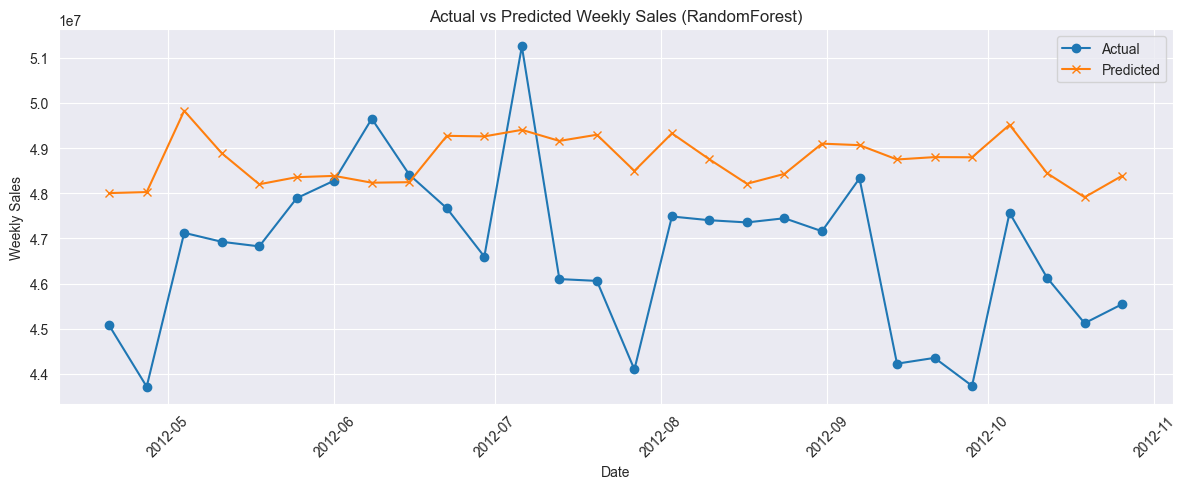

In [114]:
# Plot actual vs predicted for best model
plt.figure(figsize=(12,5))
plt.plot(dates_test, y_test.values, label='Actual', marker='o')
plt.plot(dates_test, best_pred, label='Predicted', marker='x')
plt.title(f'Actual vs Predicted Weekly Sales ({best_name})')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [115]:
# Forecast next period
last_dates = model_data.tail(5).copy()
last_sales = last_dates['Weekly_Sales'].values
next_date = model_data['Date'].max() + pd.Timedelta(days=7)
row = {'Date': next_date, 'year': next_date.year, 'month': next_date.month, 'week': next_date.isocalendar().week,
       'dayofweek': next_date.dayofweek, 'lag_1': last_sales[-1],
       'lag_2': last_sales[-2] if len(last_sales) >= 2 else last_sales[-1],
       'lag_4': last_sales[-4] if len(last_sales) >= 4 else last_sales[0]}
for c in exog_cols:
    row[c] = model_data[c].iloc[-1]
future_df = pd.DataFrame([row])
future_X = future_df[cols_for_model]
future_pred = best_model.predict(future_X)[0]
print('Next week date:', next_date.date(), 'Forecasted Weekly Sales:', round(future_pred,2))


Next week date: 2012-11-02 Forecasted Weekly Sales: 49852220.93


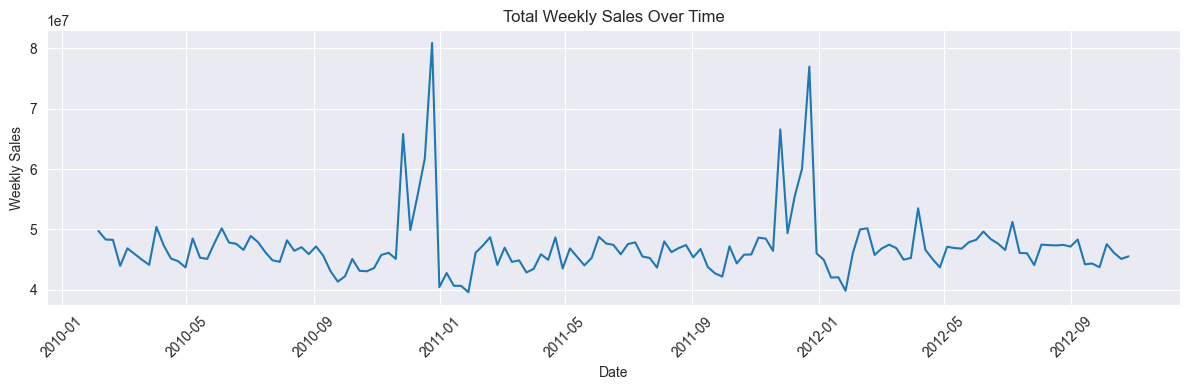

In [116]:
# Plot overall weekly sales trend
plt.figure(figsize=(12,4))
plt.plot(data['Date'], data['Weekly_Sales'], color='tab:blue')
plt.title('Total Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


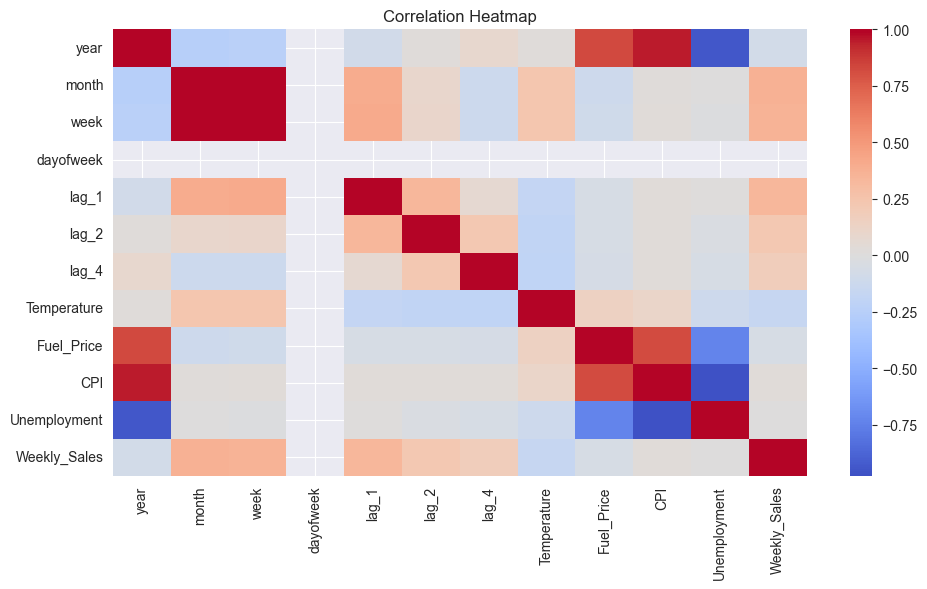

In [117]:
# Plot correlation heatmap of numeric features
num_for_corr = model_data[cols_for_model + ['Weekly_Sales']].corr()
plt.figure(figsize=(10,6))
sns.heatmap(num_for_corr, cmap='coolwarm', center=0, annot=False)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


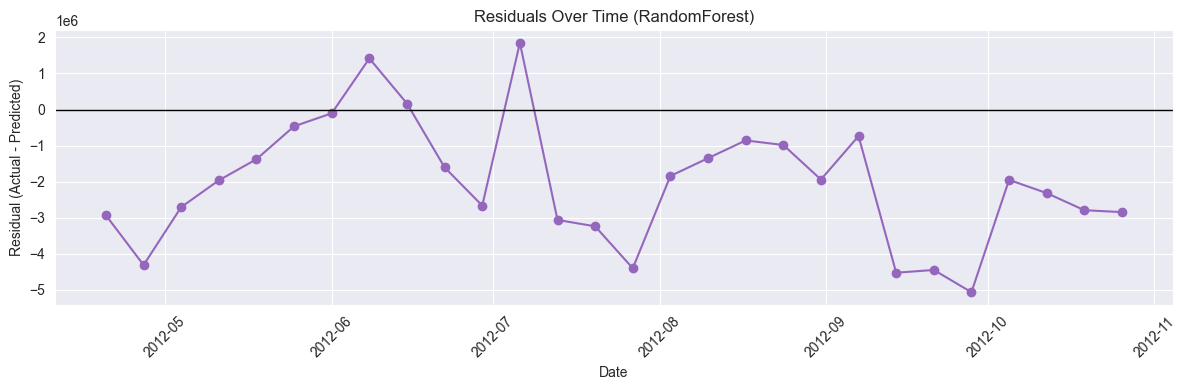

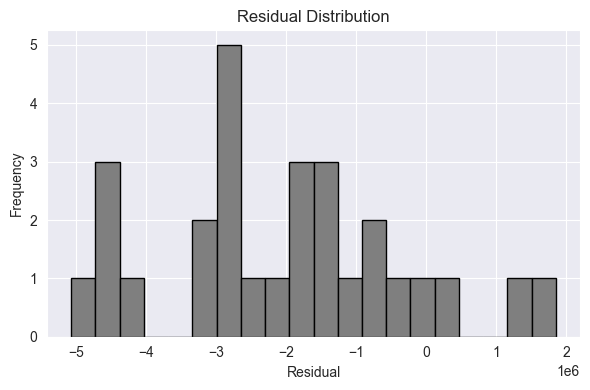

Residual mean: -2036530.26 Residual std: 1698174.76


In [118]:
# Residual analysis for best model
residuals = y_test.values - best_pred
plt.figure(figsize=(12,4))
plt.plot(dates_test, residuals, marker='o', linestyle='-', color='tab:purple')
plt.axhline(0, color='black', linewidth=1)
plt.title(f'Residuals Over Time ({best_name})')
plt.xlabel('Date')
plt.ylabel('Residual (Actual - Predicted)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=20, color='tab:gray', edgecolor='black')
plt.title('Residual Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
print('Residual mean:', round(np.mean(residuals),2), 'Residual std:', round(np.std(residuals),2))


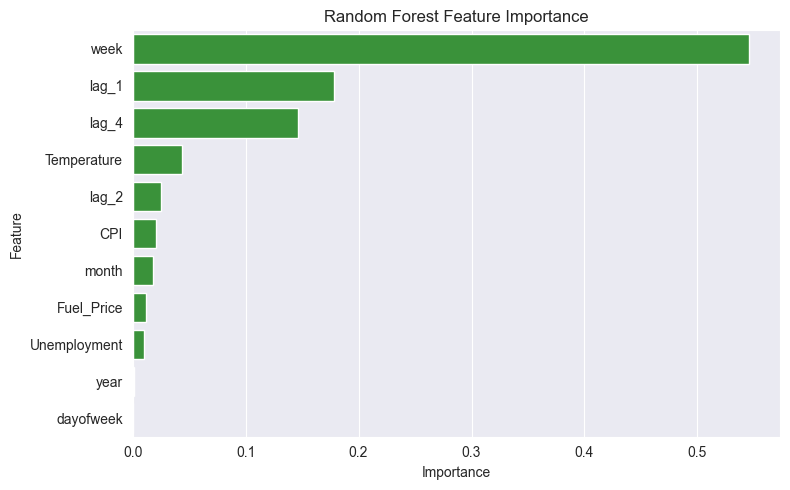

week            0.545837
lag_1           0.178340
lag_4           0.146395
Temperature     0.043257
lag_2           0.025440
CPI             0.020318
month           0.017691
Fuel_Price      0.011690
Unemployment    0.009849
year            0.001184
dtype: float64


In [119]:
# Feature importance for random forest (if selected or for reference)
if hasattr(rf, 'feature_importances_'):
    importances = pd.Series(rf.feature_importances_, index=cols_for_model).sort_values(ascending=False)
    plt.figure(figsize=(8,5))
    sns.barplot(x=importances.values, y=importances.index, color='tab:green')
    plt.title('Random Forest Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    print(importances.head(10))


In [120]:
# Add rolling average features
model_data_xgb = model_data.copy()
model_data_xgb['roll_mean_4'] = model_data_xgb['Weekly_Sales'].rolling(4).mean()
model_data_xgb['roll_mean_8'] = model_data_xgb['Weekly_Sales'].rolling(8).mean()
model_data_xgb['roll_mean_12'] = model_data_xgb['Weekly_Sales'].rolling(12).mean()
model_data_xgb = model_data_xgb.dropna(subset=['roll_mean_4','roll_mean_8','roll_mean_12']).reset_index(drop=True)
roll_features = ['roll_mean_4','roll_mean_8','roll_mean_12']
cols_for_model_xgb = cols_for_model + roll_features
X_full = model_data_xgb[cols_for_model_xgb]
y_full = model_data_xgb['Weekly_Sales']
split_idx_xgb = int(len(X_full)*0.8)
X_train_xgb, X_test_xgb = X_full.iloc[:split_idx_xgb], X_full.iloc[split_idx_xgb:]
y_train_xgb, y_test_xgb = y_full.iloc[:split_idx_xgb], y_full.iloc[split_idx_xgb:]
dates_test_xgb = model_data_xgb['Date'].iloc[split_idx_xgb:]
print('XGBoost feature columns:', cols_for_model_xgb)
print('Train rows (XGBoost):', X_train_xgb.shape[0], 'Test rows (XGBoost):', X_test_xgb.shape[0])


XGBoost feature columns: ['year', 'month', 'week', 'dayofweek', 'lag_1', 'lag_2', 'lag_4', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'roll_mean_4', 'roll_mean_8', 'roll_mean_12']
Train rows (XGBoost): 102 Test rows (XGBoost): 26


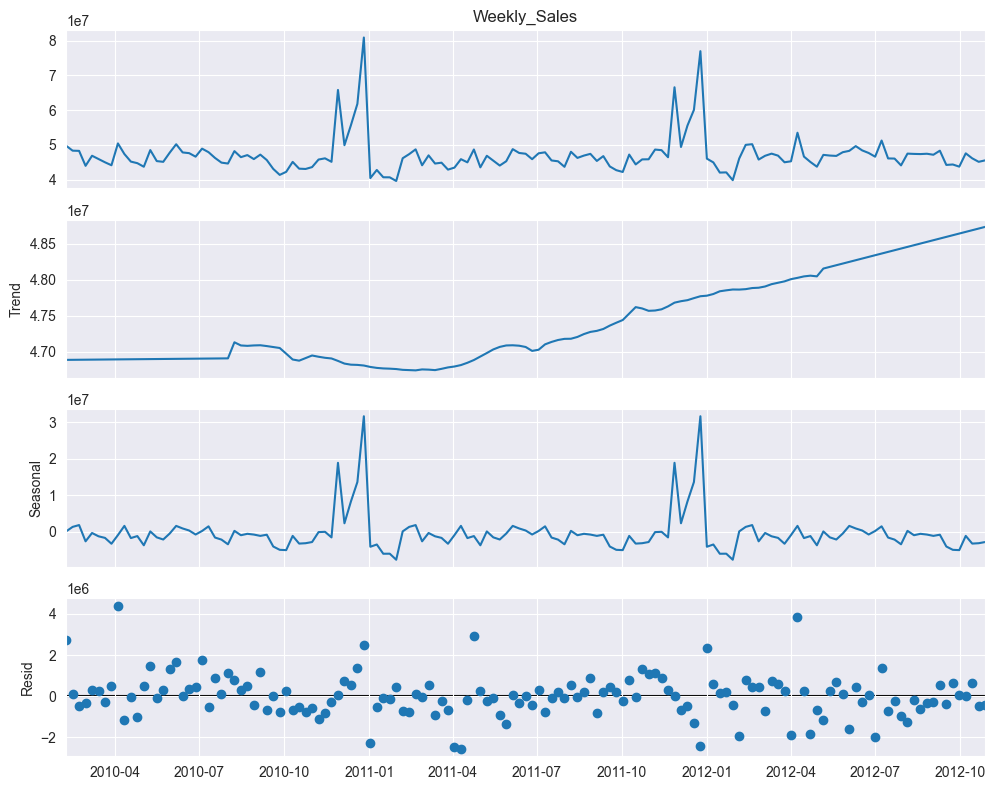

Decomposition components generated with period: 52


In [121]:
# Seasonal decomposition of weekly sales
series = data.set_index('Date')['Weekly_Sales'].sort_index()
series = series.resample('W').sum()
series = series.interpolate()
period_guess = 52
if len(series) < period_guess * 2:
    period_guess = max(2, len(series)//2)
if period_guess < 2:
    print('Not enough data points for seasonal decomposition; skipping.')
else:
    decomp = seasonal_decompose(series, model='additive', period=period_guess, extrapolate_trend='freq')
    fig = decomp.plot()
    fig.set_size_inches(10,8)
    plt.tight_layout()
    plt.show()
    print('Decomposition components generated with period:', period_guess)


In [123]:
# Time-series cross-validation with XGBoost
tscv = TimeSeriesSplit(n_splits=5)
cv_mae = []
cv_rmse = []
for i,(train_idx, val_idx) in enumerate(tscv.split(X_train_xgb)):
    X_tr, X_val = X_train_xgb.iloc[train_idx], X_train_xgb.iloc[val_idx]
    y_tr, y_val = y_train_xgb.iloc[train_idx], y_train_xgb.iloc[val_idx]
    xgb = XGBRegressor(objective='reg:squarederror', n_estimators=300, max_depth=6, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9, random_state=42, reg_lambda=1.0, n_jobs=-1)
    xgb.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
    pred_val = xgb.predict(X_val)
    mae_val = mean_absolute_error(y_val, pred_val)
    rmse_val = mean_squared_error(y_val, pred_val)
    cv_mae.append(mae_val)
    cv_rmse.append(rmse_val)
    print(f'Fold {i+1} MAE: {mae_val:.2f} RMSE: {rmse_val:.2f}')
print('CV MAE mean:', round(np.mean(cv_mae),2), 'CV RMSE mean:', round(np.mean(cv_rmse),2))


Fold 1 MAE: 6781587.67 RMSE: 111825773996740.09
Fold 2 MAE: 3429212.56 RMSE: 39024150138732.45
Fold 3 MAE: 1133386.56 RMSE: 2328707342935.75
Fold 4 MAE: 2700711.87 RMSE: 22312677865791.96
Fold 5 MAE: 2136952.69 RMSE: 6758256875041.71
CV MAE mean: 3236370.27 CV RMSE mean: 36449913243848.39


XGBoost Hold-out MAE: 1639672.06 RMSE: 4024998473512.57


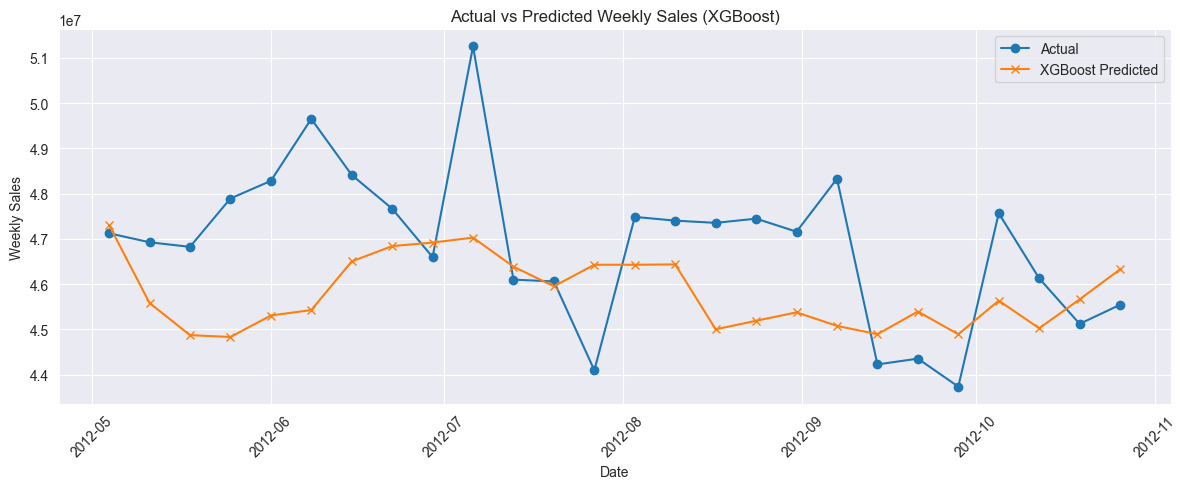

In [125]:
# Train final XGBoost and evaluate on hold-out
xgb_final = XGBRegressor(objective='reg:squarederror', n_estimators=500, max_depth=6, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9, random_state=42, reg_lambda=1.0, n_jobs=-1)
xgb_final.fit(X_train_xgb, y_train_xgb)
pred_xgb = xgb_final.predict(X_test_xgb)
mae_xgb = mean_absolute_error(y_test_xgb, pred_xgb)
rmse_xgb = mean_squared_error(y_test_xgb, pred_xgb)
print('XGBoost Hold-out MAE:', round(mae_xgb,2), 'RMSE:', round(rmse_xgb,2))
plt.figure(figsize=(12,5))
plt.plot(dates_test_xgb, y_test_xgb.values, label='Actual', marker='o')
plt.plot(dates_test_xgb, pred_xgb, label='XGBoost Predicted', marker='x')
plt.title('Actual vs Predicted Weekly Sales (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [126]:
# Advanced summary
print('Previous best model:', best_name, 'RMSE:', round(best_rmse,2))
print('XGBoost CV RMSE mean:', round(np.mean(cv_rmse),2))
print('XGBoost Hold-out RMSE:', round(rmse_xgb,2))
print('Improvement (lower is better):', round(best_rmse - rmse_xgb,2))


Previous best model: RandomForest RMSE: 7031252995017.49
XGBoost CV RMSE mean: 36449913243848.39
XGBoost Hold-out RMSE: 4024998473512.57
Improvement (lower is better): 3006254521504.92
